<a href="https://colab.research.google.com/github/drawnator/Password-optimizer/blob/main/Grupo8_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ferramenta Otimizadora De Aleatoriedade em senhas
---
Modelo de linguagem que auxilia a tornar senhas mais fortes, com base em critérios de fortificação de senhas como o [zxcvbn](https://github.com/dropbox/zxcvbn) e em [senhas vazadas da plataforma rockyou](https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt).

A aplicação prática do modelo é analisar a senha de entrada, identificar se ela é fraca ou forte segundo critérios predefinidos, se é uma senha comum (presentes na base de dados de senhas vazadas) ou não, e, por fim, dar sugestões pontuais de como tornar a senha mais improvável de adivinhar.

Assuntos:
- Análise de frequência
- Masked language model

Tecnologias utilizadas:
- RNN
- Árvores de decisão
- ZXCVBN
- Bert?
- tsne?
- Princípios de senha aleatória

##Preparando o ambiente de execução (imports necessários)

In [2]:
!pip install zxcvbn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 9.1 MB/s eta 0:00:00


In [3]:
import requests
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, SimpleRNN
from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.utils import Sequence

import matplotlib.pyplot as plt
from google.colab import drive
import pickle

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from zxcvbn import zxcvbn

In [6]:
import tqdm

## Preparando os dados

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
path = "rockyou.txt"
path = '/content/drive/MyDrive/my_models/rockyout.txt'


Mounted at /content/drive


In [7]:
# RECOMENDO FORTEMENTE BAIXAR E ARRASTAR MANUALMENTE ATÉ ARTIGOS, ISSO AQUI DEMORA MT \/
url = "https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt"
#download from github using wget
!wget {url} -O rockyou.txt

--2025-09-26 11:45:01--  https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/97553311/d4f580f8-6b49-11e7-8f70-7f460f85ab3a?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-09-26T12%3A32%3A33Z&rscd=attachment%3B+filename%3Drockyou.txt&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-09-26T11%3A32%3A09Z&ske=2025-09-26T12%3A32%3A33Z&sks=b&skv=2018-11-09&sig=RH7Jt6jZKOQ3n8vMWtLwSIQWvQO%2FWqFctlCcRdctYmU%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1ODg4NzQwMSwibmJmIjoxNzU4ODg3MTAxLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9

In [8]:
with open("rockyou.txt", "r", encoding='latin-1') as f:
  df = pd.DataFrame(f.readlines(), columns=['password'])

In [9]:
df['password'] = df['password'].str.replace('\n', '')

In [ ]:
# if not os.path.exists("rockyou.csv"):
#   df.to_csv("rockyou.csv")

In [10]:
df = df[df['password'].str.len() > 1]
display(df.shape)

(14344345, 1)

In [11]:
df, _ = train_test_split(df, test_size=0.99, random_state=42)

In [12]:
df.shape

(143443, 1)

In [13]:
df = df.reset_index(drop=True)
display(df.head())

,password
0,giannaki
1,zajuncid
2,brianne503084
3,ghjnbyu
4,mytchett


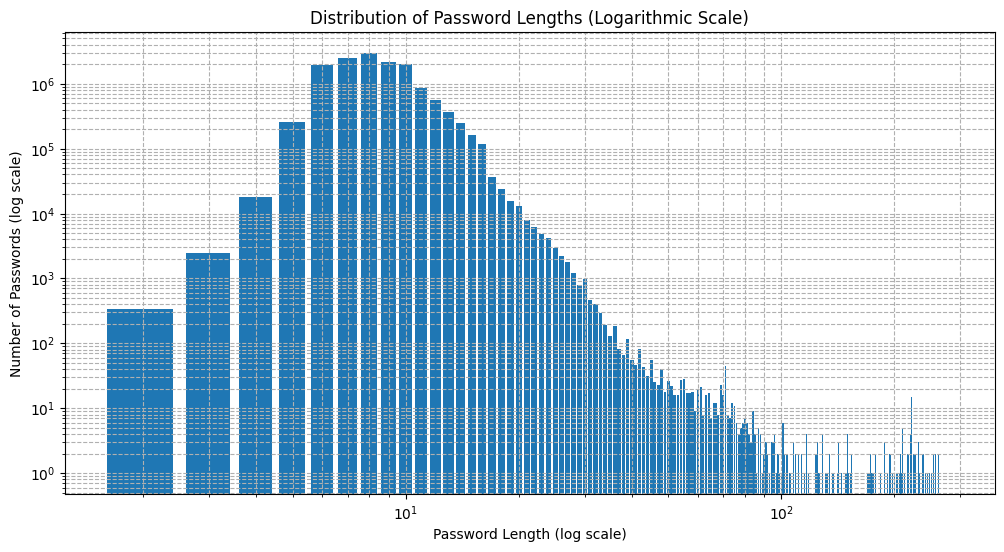

In [19]:
df['password_length'] = df['password'].str.len()

length_counts = df['password_length'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(length_counts.index, length_counts.values)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Password Length (log scale)')
plt.ylabel('Number of Passwords (log scale)')
plt.title('Distribution of Password Lengths (Logarithmic Scale)')
plt.grid(True, which="both", ls="--")
plt.show()

# Métodos de avaliar a qualidade de uma senha

# RNN

Previsibilidade de caracteres, com base em uma parte da senha o quão fácil é prever o resto dela?


## Tokenização

Transformando os caracteres de uma senha em tokens para que eles estejam no formato adequado para o processamento.

In [20]:
all_chars = sorted(list(set(''.join(df['password']))))
char_to_int = {char: i for i, char in enumerate(all_chars)}
int_to_char = {i: char for char, i in char_to_int.items()}

In [21]:
char_to_int['[MASK]'] = len(char_to_int)
char_to_int['[CLS]'] = len(char_to_int)
char_to_int['[SEP]'] = len(char_to_int)
char_to_int['[PAD]'] = len(char_to_int)
int_to_char = {i: char for char, i in char_to_int.items()}

In [22]:
class RNNTokenizer():
  def __init__(self, char_to_int,int_to_char,max_length = 32):
    self.char_to_int = char_to_int
    self.int_to_char = int_to_char
    self.mask_token_id = char_to_int['[MASK]']
    self.cls_token_id = char_to_int['[CLS]']
    self.sep_token_id = char_to_int['[SEP]']
    self.pad_token_id = char_to_int['[PAD]']
    self.max_length = max_length
    self.vocab_size = len(char_to_int)

  def __call__(self,text):
    token = [self.pad_token_id] * self.max_length
    text = f"{text:>{self.max_length}}"
    # print(text)
    for i in range(self.max_length):
      token[-i] = char_to_int[text[-i]]

    # for i in range(self.max_length):
    #   if (i < len(text)):
    #     token.append(char_to_int[text[i]])
    #   else:
    #     token.append(char_to_int['[PAD]'])

    return token

In [23]:
rnntokenizer = RNNTokenizer(char_to_int,int_to_char)

In [28]:
from google.colab import drive
import pickle
import os

drive.mount('/content/drive')

# Define the path to save the dictionaries in your Google Drive
char_to_int_path = '/content/drive/MyDrive/my_models/char_to_int_full.pkl'
int_to_char_path = '/content/drive/MyDrive/my_models/int_to_char_full.pkl'


# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(char_to_int_path), exist_ok=True)

# Save the dictionaries
with open(char_to_int_path, 'wb') as f:
    pickle.dump(char_to_int, f)

with open(int_to_char_path, 'wb') as f:
    pickle.dump(int_to_char, f)

print(f"char_to_int saved to: {char_to_int_path}")
print(f"int_to_char saved to: {int_to_char_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
char_to_int saved to: /content/drive/MyDrive/my_models/char_to_int_full.pkl
int_to_char saved to: /content/drive/MyDrive/my_models/int_to_char_full.pkl


In [12]:
from google.colab import drive
import pickle
import os

drive.mount('/content/drive')

char_to_int_path = '/content/drive/MyDrive/my_models/char_to_int1.pkl'
int_to_char_path = '/content/drive/MyDrive/my_models/int_to_char1.pkl'

# Load the dictionaries
with open(char_to_int_path, 'rb') as f:
    char_to_int = pickle.load(f)

with open(int_to_char_path, 'rb') as f:
    int_to_char = pickle.load(f)

# Create the RNNTokenizer instance
rnntokenizer = RNNTokenizer(char_to_int, int_to_char)
print("Dictionaries loaded and RNNTokenizer created.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dictionaries loaded and RNNTokenizer created.


In [29]:
print(rnntokenizer.vocab_size)

218


In [24]:
class RNNDataloader(Sequence):
  def __init__(self,dataframe,tokenizer,batch_size=100):
    self.dataframe = dataframe
    self.tokenizer = tokenizer
    self.batch_size = batch_size

  def mask_and_tokens(self,password):
      i = np.random.randint(1, min(len(password),self.tokenizer.max_length))
      label = self.tokenizer.char_to_int[password[i]]
      input_seq = self.tokenizer(password[:i])

      # input_seq += [self.tokenizer.mask_token_id]
      # input_seq += [self.tokenizer.pad_token_id] * (self.tokenizer.max_length - len(input_seq))
      return input_seq,label

  def __len__(self):
    return len(self.dataframe) // self.batch_size

  def __getitem__(self, idx):
    batch = self.dataframe[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_inputs = []
    batch_labels = []
    for password in batch:
      input_seq, label = self.mask_and_tokens(password)
      batch_inputs.append(input_seq)
      batch_labels.append(label)
    return np.array(batch_inputs), np.array(batch_labels)

In [25]:
dataloader = RNNDataloader(df['password'],rnntokenizer,1)

In [26]:
df["password"][0]

'123456'

In [30]:
dataloader[0]

(array([[ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 21, 22]]),
 array([23]))

## Dividindo os dados em conjuntos de treino, validação e teste

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def create_train_val_test_arrays(df, dataloader, tokenizer, test_size=0.2, val_size=0.5,):
    train_df, temp_df = train_test_split(df, test_size=test_size, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=val_size, random_state=42)

    train_dataloader = dataloader(train_df, tokenizer,batch_size=1000)
    val_dataloader = dataloader(val_df, tokenizer,batch_size=1000)
    test_dataloader = dataloader(test_df, tokenizer,batch_size=1000)

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
train_dataloader,val_dataloader,test_dataloader = create_train_val_test_arrays(df["password"], RNNDataloader, rnntokenizer)

## Definindo o modelo

### training model

In [ ]:
#https://colab.research.google.com/drive/1mts5E3yAd1irLzS7Ei6UtwbG773C87DB?usp=sharing
model = Sequential([
    Embedding(
        input_dim=rnntokenizer.vocab_size,
        output_dim=100,
        input_shape=(rnntokenizer.max_length,)),
    Bidirectional(SimpleRNN(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(SimpleRNN(64, return_sequences=False)),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.05),
    Dense(128, activation='relu'),
    Dense(rnntokenizer.vocab_size, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 32, 100)        │        19,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 32, 128)        │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 194)            │        25,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,590 (517.93 KB)

 Trainable params: 132,590 (517.93 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_dataloader,
    validation_data=(val_dataloader),
    epochs=5,
    batch_size=128,#256
    verbose=1)

Epoch 1/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - accuracy: 0.1164 - loss: 3.2005 - val_accuracy: 0.1563 - val_loss: 2.8624
Epoch 2/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.1566 - loss: 2.8778 - val_accuracy: 0.1674 - val_loss: 2.8176
Epoch 3/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.1626 - loss: 2.8450 - val_accuracy: 0.1731 - val_loss: 2.7986
Epoch 4/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.1678 - loss: 2.8268 - val_accuracy: 0.1766 - val_loss: 2.7878
Epoch 5/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.1697 - loss: 2.8173 - val_accuracy: 0.1795 - val_loss: 2.7752
Epoch 6/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.1717 - loss: 2.8091 - val_accuracy: 0.1790 - val_loss: 2.7724
Epoch 7/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.1727 - loss: 2.8036 - val_accuracy: 0.1823 - val_loss: 2.7620
Epoch 8/10
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.1757 -

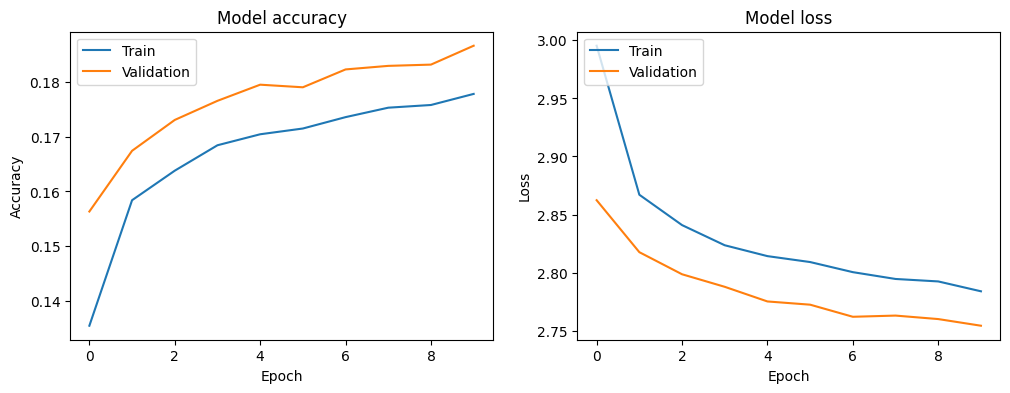

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

model_save_path = '/content/drive/MyDrive/my_models/rnn_password_model7.keras'

import os
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model.save(model_save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### load model

In [32]:
from google.colab import drive
import tensorflow as tf

drive.mount('/content/drive')

model_load_path = '/content/drive/MyDrive/my_models/rnn_password_model7.keras'

model = tf.keras.models.load_model(model_load_path)
model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 32, 100)        │        21,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32, 128)        │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 218)            │        28,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,260 (1.58 MB)

 Trainable params: 138,086 (539.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 276,174 (1.05 MB)

## métricas de modelo

In [33]:
class RnnMetrics():
  def __init__(self,model:tf.keras.models.Model,tokenizer:RNNTokenizer):
    self.model = model
    self.tokenizer = tokenizer

  def preencher_senha(self,senha_base):
    while len(senha_base) < self.tokenizer.max_length:
      senha_base += self.prever_proxima(senha_base)
    return senha_base

  def prever_proxima(self,palavras):
      seq = self.tokenizer(palavras)
      seq = np.array([seq])
      pred = self.model.predict(seq, verbose=0)
      idx = np.argmax(pred)
      return self.tokenizer.int_to_char[idx]

  def get_probs(self,palavra,temperatura=1.0):
    seq = self.tokenizer(palavra)
    seq = np.array([seq])
    pred = self.model.predict(seq, verbose=0)
    logits = np.log(pred + 1e-9) / temperatura  # evita log(0)
    exp_logits = np.exp(logits)
    probs = exp_logits / np.sum(exp_logits)
    return probs

  def get_char_rarity(self,probs,char):
    char_token = self.tokenizer.char_to_int[char]
    smaller_than = np.where(probs < probs[0][char_token])[0]
    return smaller_than.shape[0]/self.tokenizer.vocab_size

  def get_rarity(self,password):
    rarity = []
    for part in range(len(password)):
      probs = self.get_probs(password[:part])
      rarity.append(self.get_char_rarity(probs,password[part]))
    return rarity

  def get_char_proportional_probability(self,probs,char):
    char_token = self.tokenizer.char_to_int[char]
    return probs[0][char_token]

  def get_proportional_probability(self,password):
    rarity = []
    for part in range(len(password)):
      probs = self.get_probs(password[:part])
      rarity.append(self.get_char_proportional_probability(probs,password[part]))
    return rarity

  def get_weighted_scores(self,password,weight=[1,1]):
    rarity = self.get_rarity(password)
    proportional_probability = self.get_proportional_probability(password)
    return (np.array(rarity) * weight[0] + np.array(proportional_probability) * weight[1])/sum(weight)

  def get_rarer_alternatives(self,password):
    probs = self.get_probs(password[:len(password)])
    rarer_alternatives = np.where(probs[0] < probs[0][self.tokenizer.char_to_int[password[-1]]])[0]
    return [self.tokenizer.int_to_char[i] for i in rarer_alternatives]



In [34]:
rnnmetrics = RnnMetrics(model,rnntokenizer)

In [35]:
rnnmetrics.get_probs("i")

array([[1.08030840e-09, 1.04474074e-09, 1.56272173e-09, 1.05537967e-09,
        5.79822157e-03, 7.94337320e-05, 3.31804131e-06, 5.12165279e-05,
        3.97258264e-05, 4.56319867e-06, 1.88971389e-04, 1.41202332e-03,
        3.63322499e-04, 1.20018994e-05, 2.14432235e-04, 6.29841816e-05,
        3.54117190e-04, 1.45795697e-03, 5.19600522e-04, 4.83369004e-05,
        2.50756950e-03, 4.36841697e-03, 2.95648212e-03, 1.55284780e-03,
        1.45132933e-03, 1.48592144e-03, 1.00157002e-03, 1.31850224e-03,
        2.17932905e-03, 1.86198123e-03, 1.25297420e-05, 1.59969015e-04,
        3.44992289e-03, 7.55860674e-05, 4.90362982e-06, 3.74380943e-05,
        1.73919674e-04, 3.52854404e-05, 3.40277475e-05, 3.12613738e-05,
        1.98847574e-05, 1.59260344e-05, 1.19928363e-05, 3.02171738e-05,
        5.80527521e-05, 7.49263290e-06, 1.87008009e-05, 4.31767476e-05,
        3.57164565e-04, 9.62542472e-05, 8.11075661e-05, 2.27743221e-05,
        2.83010722e-05, 1.04499686e-05, 7.47304730e-05, 5.417116

In [36]:
rnnmetrics.preencher_senha("passwo")

'password123456799100000070303030'

In [37]:
rnnmetrics.get_proportional_probability("password12345")

[np.float32(0.03674563),
 np.float32(0.22743146),
 np.float32(0.068196245),
 np.float32(0.3655133),
 np.float32(0.015787784),
 np.float32(0.13803862),
 np.float32(0.44022638),
 np.float32(0.47404578),
 np.float32(0.14415048),
 np.float32(0.21190882),
 np.float32(0.7315842),
 np.float32(0.8053402),
 np.float32(0.94908816)]

### visualizar métricas do modelo

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings

def plot_rnn_probability_heatmap(probabilities, tokenizer):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        vocab_size = len(tokenizer.char_to_int)
        grid_size = math.ceil(math.sqrt(vocab_size))
        padded_probs = list(probabilities[0]) + [0.0] * (grid_size * grid_size - vocab_size)

        heatmap_data = np.array(padded_probs).reshape(grid_size, grid_size)

        plt.figure(figsize=(grid_size * 0.5, grid_size * 0.5))
        plt.imshow(heatmap_data, cmap='viridis', aspect='auto', vmin=0.0, vmax=1.0)
        plt.colorbar(label='Probability')

        for i in range(grid_size):
            for j in range(grid_size):
                index = i * grid_size + j
                if index < vocab_size:
                    char = tokenizer.int_to_char[index]
                    prob = heatmap_data[i, j]
                    text_color = 'white' if prob < 0.5 else 'black'
                    plt.text(j, i, char, ha='center', va='center', color=text_color, fontsize=16)

        plt.title("RNN Probability Heatmap")
        plt.yticks([])
        plt.xticks([])
        plt.tight_layout()
        plt.show()

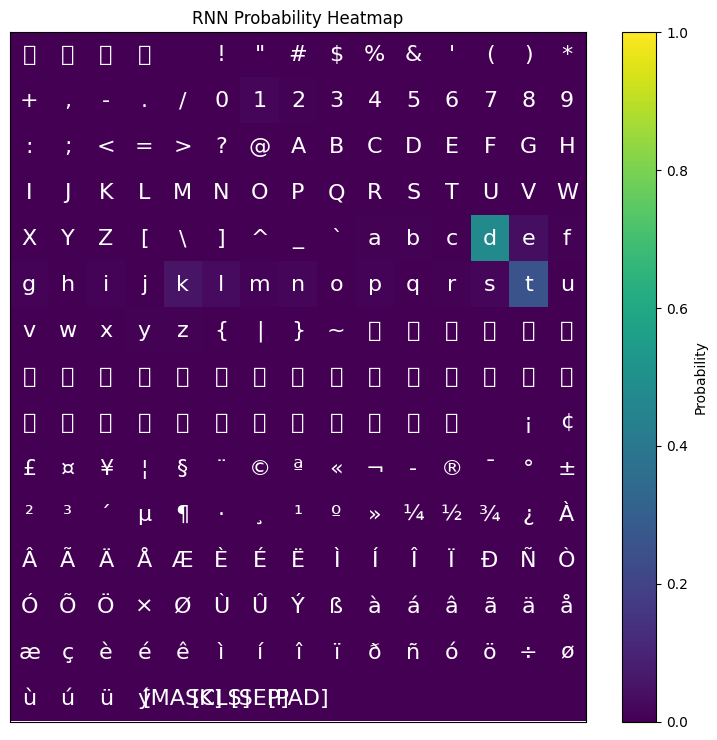

In [39]:
plot_rnn_probability_heatmap(rnnmetrics.get_probs("passwor"), rnntokenizer)

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings

def plot_rnn_rank_heatmap(probabilities, tokenizer):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        vocab_size = len(tokenizer.char_to_int)
        grid_size = math.ceil(math.sqrt(vocab_size))
        padded_probs = list(probabilities[0]) + [0.0] * (grid_size * grid_size - vocab_size)

        indices  = np.argsort(padded_probs)
        rank = np.zeros_like(indices)
        rank[indices] = np.arange(len(indices))
        rank = rank/rank.shape[0]

        heatmap_data = np.array(rank).reshape(grid_size, grid_size)

        plt.figure(figsize=(grid_size * 0.5, grid_size * 0.5))
        plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
        plt.colorbar(label='Probability')

        for i in range(grid_size):
            for j in range(grid_size):
                index = i * grid_size + j
                if index < vocab_size:
                    char = tokenizer.int_to_char[index]
                    prob = heatmap_data[i, j]
                    text_color = 'white' if prob < 0.5 else 'black'
                    plt.text(j, i, char, ha='center', va='center', color=text_color, fontsize=16)

        plt.title("RNN Probability Heatmap")
        plt.yticks([])
        plt.xticks([])
        plt.tight_layout()
        plt.show()

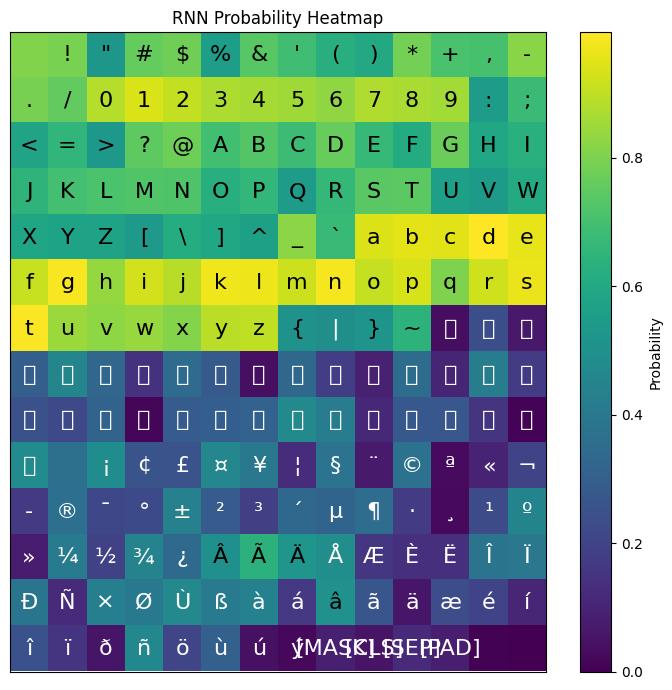

In [ ]:
plot_rnn_rank_heatmap(rnnmetrics.get_probs("passwor"), rnntokenizer)

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings

def plot_rnn_combined_heatmap(probabilities, tokenizer):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        vocab_size = len(tokenizer.char_to_int)
        grid_size = math.ceil(math.sqrt(vocab_size))
        padded_probs = list(probabilities[0]) + [0.0] * (grid_size * grid_size - vocab_size)

        indices  = np.argsort(padded_probs)
        rank = np.zeros_like(indices)
        rank[indices] = np.arange(len(indices))
        rank = rank/rank.shape[0]

        rank = rank+padded_probs

        heatmap_data = np.array(rank).reshape(grid_size, grid_size)

        plt.figure(figsize=(grid_size * 0.5, grid_size * 0.5))
        plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
        plt.colorbar(label='Probability')

        for i in range(grid_size):
            for j in range(grid_size):
                index = i * grid_size + j
                if index < vocab_size:
                    char = tokenizer.int_to_char[index]
                    prob = heatmap_data[i, j]
                    text_color = 'white' if prob < 0.5 else 'black'
                    plt.text(j, i, char, ha='center', va='center', color=text_color, fontsize=16)

        plt.title("RNN Probability Heatmap")
        plt.yticks([])
        plt.xticks([])
        plt.tight_layout()
        plt.show()

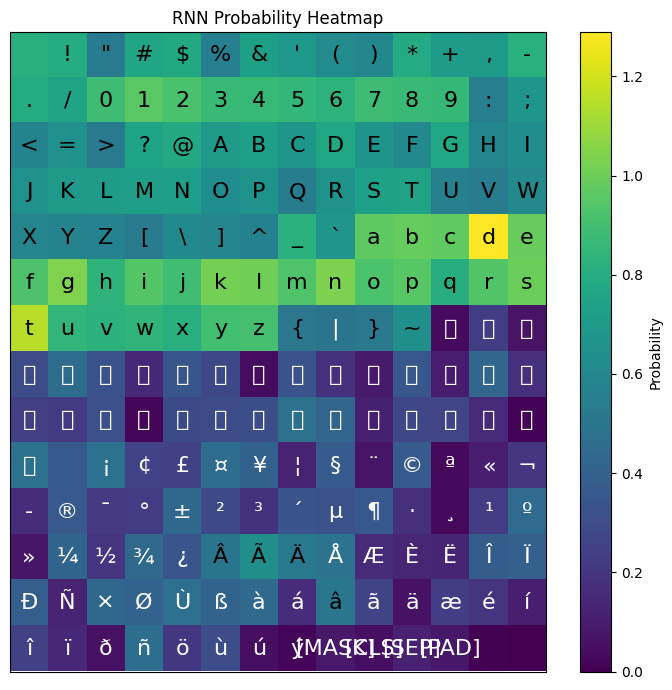

In [ ]:
plot_rnn_combined_heatmap(rnnmetrics.get_probs("passwor"), rnntokenizer)

In [42]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

def interactive_rnn_heatmap(password):
    if password:
        probs = rnnmetrics.get_probs(password)
        plot_rnn_combined_heatmap(probs, rnntokenizer)
    else:
        print("Please enter a password to see the heatmap.")

password_input = widgets.Text(
    value='password123',
    placeholder='Enter password',
    description='Password:',
    disabled=False
)

interact(interactive_rnn_heatmap, password=password_input);

interactive(children=(Text(value='password123', description='Password:', placeholder='Enter password'), Output…

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_score_heatmap(password, scores):
    heatmap_data = np.array(scores).reshape(1, -1)

    plt.figure(figsize=(len(password) * 0.5, 1))
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto', vmin=0.0, vmax=1)
    plt.colorbar(label='Score (0-1)')

    for i in range(len(password)):
        plt.text(i, 0, password[i], ha='center', va='center', color='white' if heatmap_data[0, i] < 0.5 else 'black')

    plt.title(f"{password}")
    plt.yticks([])
    plt.xticks([])
    plt.show()


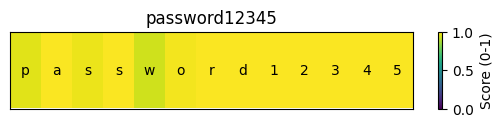

0.984121383203952


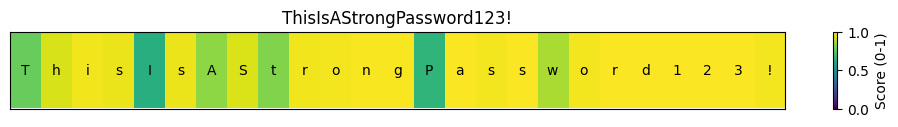

0.9289908256880735


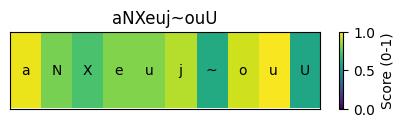

0.8105504587155963


In [44]:
password = "password12345"
rarity = rnnmetrics.get_rarity(password)
plot_score_heatmap(password, rarity)
print(sum(rarity)/len(rarity))

password = "ThisIsAStrongPassword123!"
rarity = rnnmetrics.get_rarity(password)
plot_score_heatmap(password, rarity)
print(sum(rarity)/len(rarity))

password = "aNXeuj~ouU"
rarity = rnnmetrics.get_rarity(password)
plot_score_heatmap(password, rarity)
print(sum(rarity)/len(rarity))

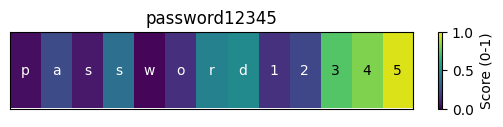

0.35446593


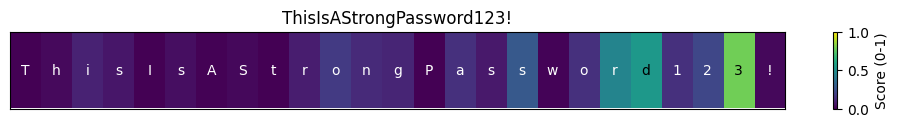

0.13993783


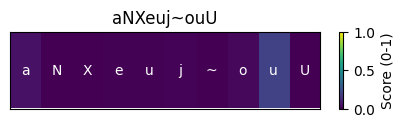

0.028985303


In [45]:
password = "password12345"
proportional = rnnmetrics.get_proportional_probability(password)
plot_score_heatmap(password, proportional)
print(sum(proportional)/len(proportional))

password = "ThisIsAStrongPassword123!"
proportional = rnnmetrics.get_proportional_probability(password)
plot_score_heatmap(password, proportional)
print(sum(proportional)/len(proportional))


password = "aNXeuj~ouU"
proportional = rnnmetrics.get_proportional_probability(password)
plot_score_heatmap(password, proportional)
print(sum(proportional)/len(proportional))


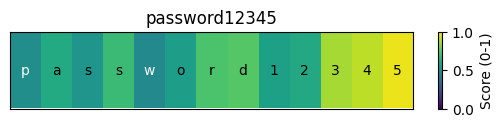

0.6692936535603935


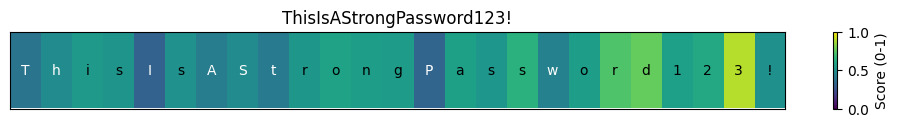

0.5344643328861929


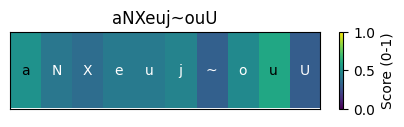

0.41976788268719645


In [46]:
password = "password12345"
weighted = rnnmetrics.get_weighted_scores(password,[1,1])
plot_score_heatmap(password,weighted )
print(sum(weighted)/len(weighted))

password = "ThisIsAStrongPassword123!"
weighted = rnnmetrics.get_weighted_scores(password,[1,1])
plot_score_heatmap(password,weighted )
print(sum(weighted)/len(weighted))

password = "aNXeuj~ouU"
weighted = rnnmetrics.get_weighted_scores(password,[1,1])
plot_score_heatmap(password,weighted )
print(sum(weighted)/len(weighted))

# Bert

## tokenização


In [14]:
from transformers import DistilBertTokenizer, TFDistilBertForMaskedLM
from transformers import BertTokenizer
from transformers import TFDistilBertForSequenceClassification

In [15]:
berttokenizer = DistilBertTokenizer.from_pretrained(
    'distilbert-base-cased',
    # do_basic_tokenize=False,
    # do_lower_case=False,
    # split_special_tokens=True,
    )
seq_length = 32

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [16]:
token = berttokenizer("aNXeuj~ouU",
                      padding='max_length',
                      truncation=True,
                      max_length=seq_length,
                      split_special_tokens=True
                      )
token

{'input_ids': [101, 170, 2249, 3190, 14272, 3361, 199, 20796, 2591, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [17]:
# Example of decoding each token individually
decoded_tokens = [berttokenizer.decode([token_id]) for token_id in token['input_ids']]
print(decoded_tokens)

['[CLS]', 'a', '##N', '##X', '##eu', '##j', '~', 'ou', '##U', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
class BertDataloader(Sequence):
  def __init__(self,dataframe,tokenizer,seq_length=32,batch_size=100):
    self.dataframe = dataframe
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.seq_length = seq_length

  def mask_and_tokens(self,password):
      token = self.tokenizer(password,
                              padding='max_length',
                              truncation=True,
                              max_length=self.seq_length,
                              split_special_tokens=True
                              )
      sep_index = token['input_ids'].index(self.tokenizer.sep_token_id)
      i = np.random.randint(1, sep_index)

      label = np.full(self.seq_length, 0, dtype=np.int32)
      label[i] = token['input_ids'][i]
      token['input_ids'][i] = self.tokenizer.mask_token_id

      return token,label

  def __len__(self):
    return len(self.dataframe) // self.batch_size

  def __getitem__(self, idx):
    batch = self.dataframe[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_inputs = {'input_ids': [], 'attention_mask': []}
    batch_labels = []
    for password in batch:
      input_seq, label = self.mask_and_tokens(password)
      batch_inputs['input_ids'].append(input_seq['input_ids'])
      batch_inputs['attention_mask'].append(input_seq['attention_mask'])
      batch_labels.append(label)

    # Convert lists to TensorFlow tensors
    batch_inputs['input_ids'] = tf.constant(batch_inputs['input_ids'], dtype=tf.int32)
    batch_inputs['attention_mask'] = tf.constant(batch_inputs['attention_mask'], dtype=tf.int32)
    batch_labels = tf.constant(batch_labels, dtype=tf.int32)

    return batch_inputs, batch_labels

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import tqdm

def create_bert_dataset(dataframe, tokenizer, seq_length, batch_size, masking_probability=0.15):
    input_ids_list = []
    attention_mask_list = []
    labels_list = []
    sample_weights_list = [] # Add list for sample weights

    for password in tqdm.tqdm(dataframe):
        token = tokenizer(password,
                          padding='max_length',
                          truncation=True,
                          max_length=seq_length,
                          split_special_tokens=True
                          )

        input_ids = token['input_ids']
        attention_mask = token['attention_mask']

        # Find indices of non-special tokens
        special_token_ids = [tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id, tokenizer.unk_token_id]
        available_indices = [i for i, token_id in enumerate(input_ids) if token_id not in special_token_ids]

        if not available_indices:
            continue

        # Determine the number of tokens to mask (15%)
        num_tokens_to_mask = max(1, int(len(available_indices) * masking_probability)) # Mask at least one token

        # Randomly select indices to mask
        masked_indices = np.random.choice(available_indices, num_tokens_to_mask, replace=False)

        label = np.full(seq_length, 0, dtype=np.int32)
        sample_weights = np.zeros(seq_length, dtype=np.float32)

        for i in masked_indices:
            # Set the label for the masked token to its original ID
            label[i] = input_ids[i]
            # Set the sample weight to 1.0 for the masked token
            sample_weights[i] = 1.0
            # Replace the original token with the mask token
            input_ids[i] = tokenizer.mask_token_id


        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        labels_list.append(label)
        sample_weights_list.append(sample_weights)


    input_ids_tensor = tf.constant(input_ids_list, dtype=tf.int32)
    attention_mask_tensor = tf.constant(attention_mask_list, dtype=tf.int32)
    labels_tensor = tf.constant(labels_list, dtype=tf.int32)
    sample_weights_tensor = tf.constant(sample_weights_list, dtype=tf.float32)


    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': input_ids_tensor,
                                                   'attention_mask': attention_mask_tensor},
                                                  labels_tensor,
                                                  sample_weights_tensor))

    dataset = dataset.shuffle(buffer_size=len(input_ids_list)).batch(batch_size)

    return dataset

## Dividindo os dados em conjuntos de treino, validação e teste

In [19]:
train_df, temp_df = train_test_split(df['password'], test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [20]:
train_dataset = create_bert_dataset(train_df, berttokenizer, seq_length, batch_size=100)
val_dataset = create_bert_dataset(val_df, berttokenizer, seq_length, batch_size=100)
test_dataset = create_bert_dataset(test_df, berttokenizer, seq_length, batch_size=100)

100%|██████████| 14345/14345 [00:03<00:00, 4426.09it/s]


In [21]:
for element in train_dataset.take(1):
    print(element[0]['input_ids'][1])
    print(element[1])

tf.Tensor(
[  101 13411   103  1708   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(32,), dtype=int32)
tf.Tensor(
[[    0     0     0 ...     0     0     0]
 [    0     0 15654 ...     0     0     0]
 [    0     0  2176 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]], shape=(100, 32), dtype=int32)


## Modelo

In [22]:
model = TFDistilBertForMaskedLM.from_pretrained('distilbert-base-cased', from_pt=True)

model.compile(
    optimizer='adam', # Use tf.keras.optimizers.Adam
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # metrics=['accuracy']
    )

pytorch_model.bin:   0%|          | 0.00/263M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForMaskedLM: ['vocab_projector.weight']
- This IS expected if you are initializing TFDistilBertForMaskedLM from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMaskedLM from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForMaskedLM for predictions withou

In [23]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    )

Epoch 1/3
1147/1147 [==============================] - ETA: 0s - loss: 0.2224

1147/1147 [==============================] - 89s 52ms/step - loss: 0.2224 - val_loss: 0.2199
Epoch 2/3
1146/1147 [============================>.] - ETA: 0s - loss: 0.2193

1147/1147 [==============================] - 59s 51ms/step - loss: 0.2193 - val_loss: 0.2202
Epoch 3/3
1146/1147 [============================>.] - ETA: 0s - loss: 0.2166

1147/1147 [==============================] - 59s 51ms/step - loss: 0.2166 - val_loss: 0.2204


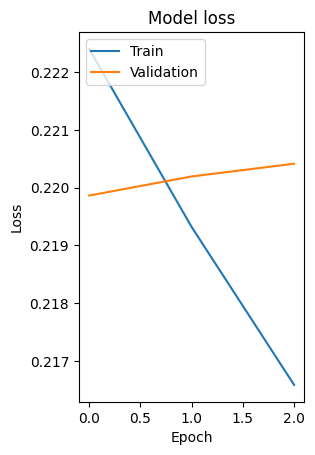

In [24]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [25]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the model in your Google Drive
# You might want to change 'bert_password_model' to a specific name
model_save_path = '/content/drive/MyDrive/my_models/bert_password_model4.keras'

# Create the directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# Save the model and tokenizer
# Use save_pretrained for Hugging Face models
model.save_pretrained(model_save_path)
berttokenizer.save_pretrained(model_save_path)

print(f"BERT model and tokenizer saved to: {model_save_path}")

Mounted at /content/drive
BERT model and tokenizer saved to: /content/drive/MyDrive/my_models/bert_password_model4.keras


In [76]:
from google.colab import drive
import tensorflow as tf
from transformers import TFDistilBertForMaskedLM

drive.mount('/content/drive')

# Define the path where the model was saved
model_load_path = '/content/drive/MyDrive/my_models/bert_password_model3.keras'

# Load the model using from_pretrained for Hugging Face models
model = TFDistilBertForMaskedLM.from_pretrained(model_load_path)

model.summary()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


All model checkpoint layers were used when initializing TFDistilBertForMaskedLM.

All the layers of TFDistilBertForMaskedLM were initialized from the model checkpoint at /content/drive/MyDrive/my_models/bert_password_model3.keras.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForMaskedLM for predictions without further training.


Model: "tf_distil_bert_for_masked_lm_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  65190912  
 inLayer)                                                        
                                                                 
 vocab_transform (Dense)     multiple                  590592    
                                                                 
 vocab_layer_norm (LayerNor  multiple                  1536      
 malization)                                                     
                                                                 
 vocab_projector (TFDistilB  multiple                  22692676  
 ertLMHead)                                                      
                                                                 
Total params: 65812036 (251.05 MB)
Trainable params: 65812036 (251.05 MB)
Non-trainable params: 0 (0.0

## Métricas

In [26]:
def evaluate_password_with_bert(password, model, tokenizer, seq_length=32):
    tokenized_password = tokenizer(password,
                                   padding='max_length',
                                   truncation=True,
                                   max_length=seq_length,
                                   return_tensors='tf',
                                   split_special_tokens=True
                                  )

    input_ids = tokenized_password['input_ids']
    attention_mask = tokenized_password['attention_mask']
    sep_index = tf.where(input_ids == tokenizer.sep_token_id)[0][1].numpy()

    if sep_index <= 1:
        print("Password too short to mask a meaningful token.")
        return None

    probabilities = []
    tokens = []
    for mask_index in range(1, sep_index):

        original_token_id = input_ids[0, mask_index].numpy()
        original_token = tokenizer.decode([original_token_id])
        tokens.append(original_token.split("##")[-1])

        masked_input_ids = tf.identity(input_ids)
        masked_input_ids = tf.tensor_scatter_nd_update(masked_input_ids, [[0, mask_index]], [tokenizer.mask_token_id])

        predictions = model({'input_ids': masked_input_ids, 'attention_mask': attention_mask})
        masked_token_logits = predictions.logits[0, mask_index, :]

        probs = tf.nn.softmax(masked_token_logits).numpy()

        probability_of_original_token = probs[original_token_id]
        probabilities.append(probability_of_original_token)

        # print(f"Masked token at index {mask_index}: '{original_token}' (ID: {original_token_id}) - Probability: {probability_of_original_token:.4f}")


    return tokens,probabilities

In [27]:
bert_tokens, probabilities= evaluate_password_with_bert("password12345",model,berttokenizer)
probabilities

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


[np.float32(3.6606496e-05),
 np.float32(0.0108571295),
 np.float32(0.00264486),
 np.float32(0.014448138)]

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_score_heatmap(password, scores):
    heatmap_data = np.array(scores).reshape(1, -1)

    plt.figure(figsize=(len(password) * 1.5, 1))
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto', vmin=0.0, vmax=1)
    plt.colorbar(label='Score (0-1)')

    for i in range(len(password)):
        plt.text(i, 0, password[i], ha='center', va='center', color='white' if heatmap_data[0, i] < 0.5 else 'black')

    plt.title(f"{password}")
    plt.yticks([])
    plt.xticks([])
    plt.show()


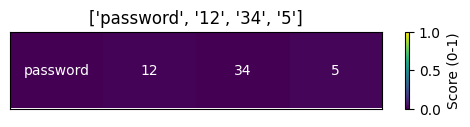

In [29]:
plot_score_heatmap(bert_tokens,probabilities)

In [30]:
def evaluate_top_password_with_bert(password, model, tokenizer, seq_length=32):
    tokenized_password = tokenizer(password,
                                   padding='max_length',
                                   truncation=True,
                                   max_length=seq_length,
                                   return_tensors='tf',
                                   split_special_tokens=True
                                  )

    input_ids = tokenized_password['input_ids']
    attention_mask = tokenized_password['attention_mask']
    sep_index = tf.where(input_ids == tokenizer.sep_token_id)[0][1].numpy()

    if sep_index <= 1:
        print("Password too short to mask a meaningful token.")
        return None

    probabilities = []
    tokens = []
    for mask_index in range(1, sep_index):

        original_token_id = input_ids[0, mask_index].numpy()
        original_token = tokenizer.decode([original_token_id])
        tokens.append(original_token.split("##")[-1])

        masked_input_ids = tf.identity(input_ids)
        masked_input_ids = tf.tensor_scatter_nd_update(masked_input_ids, [[0, mask_index]], [tokenizer.mask_token_id])

        predictions = model({'input_ids': masked_input_ids, 'attention_mask': attention_mask})
        masked_token_logits = predictions.logits[0, mask_index, :]

        probs = tf.nn.softmax(masked_token_logits).numpy()

        # print(np.sum(np.sort(probs)[-1:]))
        probability_of_original_token = probs[original_token_id] / np.sum(np.sort(probs)[-1:])
        probabilities.append(probability_of_original_token)


    return tokens,probabilities

In [31]:
bert_tokens, probabilities = evaluate_top_password_with_bert("password12345",model,berttokenizer)
probabilities

[np.float32(0.0013412619),
 np.float32(0.39780504),
 np.float32(0.09690766),
 np.float32(0.52938026)]

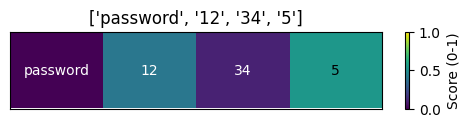

In [32]:
plot_score_heatmap(bert_tokens,probabilities)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_bert_top_probabilities_heatmap(password, model, tokenizer, seq_length=32, grid_size=10):
    """
    Plots a heatmap of the top predicted token probabilities for the *next* token
    in a password sequence using a BERT model.

    Args:
        password (str): The input password. The model will predict the token
                        immediately following this sequence.
        model (TFDistilBertForMaskedLM): The trained BERT masked language model.
        tokenizer (DistilBertTokenizer): The BERT tokenizer.
        seq_length (int): The maximum sequence length.
        grid_size (int): The size of the square grid for the heatmap (grid_size x grid_size).
    """
    # Tokenize the input password
    tokenized_password = tokenizer(password,
                                   padding='max_length',
                                   truncation=True,
                                   max_length=seq_length,
                                   return_tensors='tf',
                                   split_special_tokens=True
                                  )

    input_ids = tokenized_password['input_ids']
    attention_mask = tokenized_password['attention_mask']

    sep_index = tf.where(input_ids == tokenizer.sep_token_id)[0][1].numpy()
    prediction_index = sep_index if sep_index < seq_length -1 else seq_length -1

    predictions = model({'input_ids': input_ids, 'attention_mask': attention_mask})
    next_token_logits = predictions.logits[0, prediction_index, :]

    probs = tf.nn.softmax(next_token_logits).numpy()

    top_indices = np.argsort(probs)[::-1][:grid_size*grid_size]
    top_probs = probs[top_indices]
    top_tokens = [tokenizer.decode([i]).split("##")[-1] for i in top_indices]

    heatmap_data = top_probs.reshape(grid_size, grid_size)
    tokens_grid = np.array(top_tokens).reshape(grid_size, grid_size)


    plt.figure(figsize=(grid_size * 0.8, grid_size * 0.8))
    plt.imshow(heatmap_data, cmap='viridis', aspect='auto', vmin=0.0, vmax=np.max(top_probs))
    plt.colorbar(label='Probability')

    for i in range(grid_size):
        for j in range(grid_size):
            plt.text(j, i, tokens_grid[i, j], ha='center', va='center', color='white' if heatmap_data[i, j] < np.max(top_probs) / 2 else 'black', fontsize=10)

    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()
    plt.show()

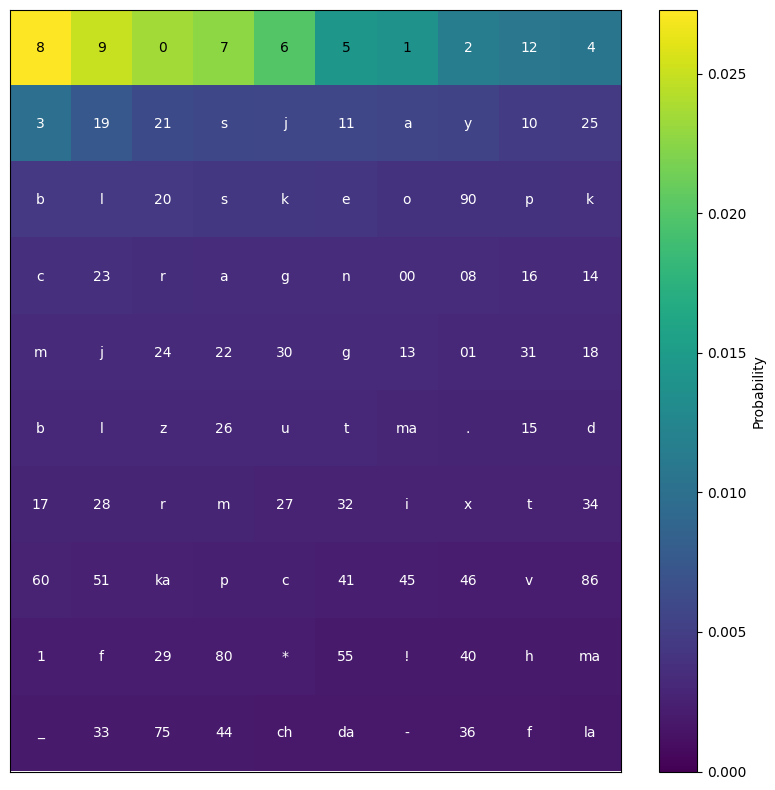

In [34]:
plot_bert_top_probabilities_heatmap("password",model,berttokenizer)

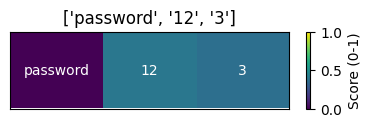

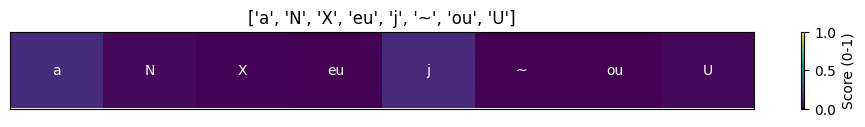

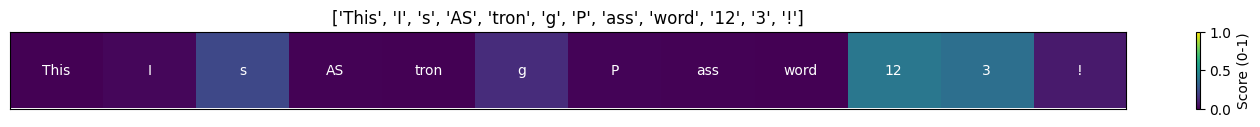

In [35]:
user_password = "password123"
bert_tokens, probabilities= evaluate_top_password_with_bert(user_password, model, berttokenizer)
plot_score_heatmap(bert_tokens,probabilities)

user_password = "aNXeuj~ouU"
bert_tokens, probabilities= evaluate_top_password_with_bert(user_password, model, berttokenizer)
plot_score_heatmap(bert_tokens,probabilities)

user_password = "ThisIsAStrongPassword123!"
bert_tokens, probabilities= evaluate_top_password_with_bert(user_password, model, berttokenizer)
plot_score_heatmap(bert_tokens,probabilities)

In [36]:
from google.colab import runtime
print("Script execution complete.")
runtime.unassign()

Script execution complete.


# ZXCVBN

In [ ]:
def zxcvbneficar(senhas):
  for s in senhas:
    resultado = zxcvbn(s)
    print(resultado)
    print(f"Senha: {s}")
    print(f"  - Pontuação (0 a 4): {resultado['score']}")
    print(f"  - Feedback: {resultado['feedback']['warning'] or 'Nenhum aviso'}")
    print(f"  - Sugestões: {resultado['feedback']['suggestions'] or 'Nenhuma'}")
    print(f"  - Tempo de quebra: {resultado['crack_times_display']['offline_fast_hashing_1e10_per_second']}")
    print("--------------------------------------------------------------------------------------------------")


senhas = [
    "password12345",
    "ThisIsAStrongPassword123!",
    "aNXeuj~ouU"
]

zxcvbneficar(senhas)

In [ ]:
for senha in senhas:
  print(senha)
  resultado = zxcvbn(senha)
  for atributo in resultado:
    print(atributo,resultado[atributo])

In [ ]:
for senha in senhas:
  print(senha)
  resultado = zxcvbn(senha)
  for sequence in resultado["sequence"]:
    print(sequence)

# iterativamente fazendo uma senha melhor

In [ ]:
import string

In [ ]:
possible_characters = list(string.ascii_letters + string.digits + string.punctuation)

In [ ]:
def make_better_password(password, metric, tokenizer, seq_length=32):
  result = zxcvbn(password)
  while result['score'] < 4:
    score = metric.get_weighted_scores(password,weight=[1,1])
    modified = False
    for sequence in result["sequence"]:
      print("found:",sequence["token"],"with",sequence['pattern'])
      if sequence['pattern'] in ['dictionary','repeat']:
        string = sequence['token']
        first_char_pos = password.find(string)
        last_char_pos = first_char_pos + len(string)
        best = np.argmax(score[first_char_pos:last_char_pos])
        best_position = first_char_pos + best
        alternatives = metric.get_rarer_alternatives(password[:best_position])
        alternatives = [a for a in alternatives if a in possible_characters]
        if alternatives:
          modified = True
          password = password[:best_position] + np.random.choice(alternatives) + password[best_position+1:]
      else:
        probs = metric.get_probs(password)[0]
        possible_characters_score = []
        for character in possible_characters:
          possible_characters_score.append(1-probs[tokenizer.char_to_int[character]])
        possible_characters_score = np.array(possible_characters_score)
        possible_characters_score = possible_characters_score / possible_characters_score.sum()
        password += np.random.choice(possible_characters,p=possible_characters_score)
        modified = True
      print("changed password to:", password)
      result = zxcvbn(password)
    if not modified:
        break
  return password


In [ ]:
print(make_better_password("password12345",rnnmetrics,rnntokenizer))

In [ ]:
print(make_better_password("ThisIsAStrongPassword123!",rnnmetrics,rnntokenizer))

In [ ]:
print(make_better_password("aNXeuj~ouU",rnnmetrics,rnntokenizer))

In [ ]:
print(make_better_password("ilovepassword",rnnmetrics,rnntokenizer))

In [ ]:
print(make_better_password("123123123123",rnnmetrics,rnntokenizer))

In [ ]:
print(make_better_password("deumaoito",rnnmetrics,rnntokenizer))